In [1]:
import sys
sys.path.append("../")

In [2]:
from pathlib import Path
from functools import partial

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from fastai.text import LanguageModelLoader, LanguageModelData
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
tokens = joblib.load("../data/tokens_word.pkl")

In [4]:
# Filter out empty rows
print(len(tokens))
tokens = [x for x in tokens if x.shape[0] > 0]
print(len(tokens))

367208
367208


In [5]:
trn_tokens, val_tokens = train_test_split(tokens, test_size=0.2, random_state=9)
val_tokens, tst_tokens = train_test_split(val_tokens, test_size=0.5, random_state=9)

In [6]:
def get_voc_stats(tokens):
    total_tokens = np.sum([x.shape[0] for x in tokens])
    unks = np.sum([np.sum(x == 1) for x in tokens])
    print("Total tokens: %d\nUnknown Percentage: %.2f %%" % (total_tokens, unks * 100 / total_tokens))
get_voc_stats(tokens)

Total tokens: 97937703
Unknown Percentage: 16.95 %


In [7]:
bptt = 50
batch_size = 64
n_tok = int(np.max([np.max(x) for x in tokens]) + 1)
trn_loader = LanguageModelLoader(
    np.concatenate(trn_tokens), batch_size, bptt)
val_loader = LanguageModelLoader(
    np.concatenate(val_tokens), batch_size, bptt)
tst_loader = LanguageModelLoader(
    np.concatenate(tst_tokens), batch_size, bptt)

In [8]:
from collections import Counter
tmp = []
for i in range(10000):
    for j in range(1, trn_tokens[i].shape[0]):
        if trn_tokens[i][j] == 1:
            tmp.append(trn_tokens[i][j-1])
Counter(tmp).most_common(10)

[(1, 70402),
 (2, 33395),
 (3, 31320),
 (5, 21166),
 (4, 18291),
 (6, 9345),
 (19, 8532),
 (8, 7118),
 (10, 6034),
 (32, 5090)]

In [9]:
from collections import Counter
tmp = []
for i in range(10000):
    for j in range(1, trn_tokens[i].shape[0]-1):
        if trn_tokens[i][j] == 4:
            tmp.append(trn_tokens[i][j+1])
Counter(tmp).most_common(10)

[(1, 18290),
 (20, 9225),
 (6, 4395),
 (16, 1642),
 (23, 1119),
 (45, 1033),
 (109, 993),
 (36, 927),
 (29, 876),
 (95, 846)]

In [10]:
mapping = joblib.load("../data/mapping_word.pkl")

In [11]:
itos = ['<pad>'] + ['<unk>'] *  n_tok
for k, v in mapping.items():
    itos[v] = k

In [12]:
itos[4]

'。'

In [13]:
path = Path("../data/cache/lm_word/")
path.mkdir(parents=True, exist_ok=True)
model_data = LanguageModelData(
    path, pad_idx=0, n_tok=n_tok, trn_dl=trn_loader, val_dl=val_loader, test_dl=tst_loader
)

### QRNN Model

In [ ]:
drops = np.array([0.05, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=500, n_layers=4,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=True
)

In [ ]:
learner.clip = 25.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

In [ ]:
lrs = 2e-3
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

In [ ]:
learner.sched.plot_lr()

In [ ]:
lrs = 5e-4
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save("lm_qrnn")
learner.save_encoder("lm_qrnn_enc")

In [ ]:
learner.load("lm_qrnn")

### LSTM

In [14]:
drops = np.array([0.1, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.7, 0.99)),
    emb_sz=300, n_hid=500, n_layers=3,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=False
)

 80%|███████▉  | 19504/24484 [17:12<04:23, 18.89it/s, loss=17]  

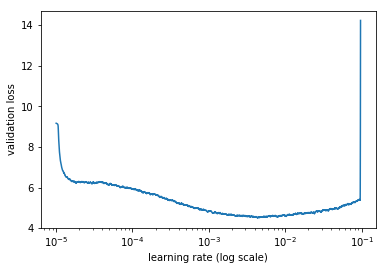

In [15]:
learner.clip = 10.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

In [16]:
lrs = 3e-3
learner.clip = 10.
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=15, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      4.345192   4.260249  
    1      4.16335    4.076405                                  
    2      4.137914   4.051645                                  
    3      4.184074   4.054441                                  
    4      4.19006    4.05613                                   
    5      4.111462   4.02054                                   
    6      4.087874   3.988497                                  
    7      4.082899   3.968057                                  
    8      4.098916   3.948941                                  
    9      4.043762   3.934794                                  
    10     4.053124   3.921426                                  
    11     4.067527   3.906694                                  
    12     4.008651   3.893846                                  
    13     4.010165   3.880458                                  
    14     3.998786   3.869341                           

[3.8693409548466935]

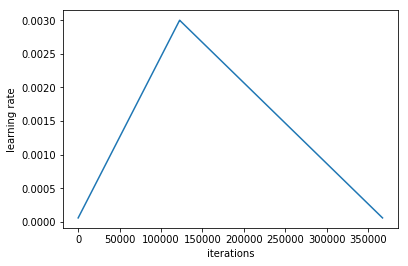

In [17]:
learner.sched.plot_lr()

In [18]:
learner.save("lm_lstm")
learner.save_encoder("lm_lstm_enc")

In [ ]:
# Use tons of memory...
# pred, targ = learner.predict_with_targs(is_test=True)

In [ ]:
tmp_iter = iter(trn_loader)

In [ ]:
next(tmp_iter)[0].shape

In [18]:
learner.load("lm_lstm")

## Test the model

In [19]:
learner.model.eval()

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(9697, 300, padding_idx=0)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(9697, 300, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(300, 500)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500)
      )
      (2): WeightDrop(
        (module): LSTM(500, 300)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=300, out_features=9697, bias=False)
    (dropout): LockedDropout()
  )
)

### Next Character Inference

In [20]:
!pip install jieba
import jieba

In [21]:
texts = "德国 是 世界 大国 之一 ， 其 国内 生产总值 以 国际 汇率 计"
tokens = list(map(lambda x: mapping.get(x, 1), texts.split(" ")))
tokens

[298, 7, 148, 7074, 226, 2, 42, 870, 6259, 25, 154, 1, 3299]

In [22]:
logits, _, _ = learner.model(T(tokens).unsqueeze(1))
logits.shape

torch.Size([13, 9697])

In [23]:
sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
preds = []
for i in range(1, 4):
      preds.append(list(map(lambda x: itos[x], sorted_idx[:, -i])))
# preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
pd.DataFrame({"orig": list(texts.split(" ")) + [" "], 
              "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

,orig,pred_1,pred_2,pred_3
0,德国,,,
1,是,<unk>,的,人
2,世界,<unk>,一,一个
3,大国,上,第一,最
4,之一,，,。,的
5,，,。,，,的
6,其,<unk>,在,并
7,国内,<unk>,在,主要
8,生产总值,<unk>,的,主要
9,以,为,<unk>,的


In [24]:
def eval(texts):
    learner.model[0].reset()
    tokens = list(map(lambda x: mapping.get(x, 1), texts))
    logits, _, _ = learner.model(T(tokens).unsqueeze(1))
    sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
    preds = []
    for i in range(1, 4):
          preds.append(list(map(lambda x: itos[x], sorted_idx[:, -i])))
    # preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
    return pd.DataFrame({"orig": [x for x in texts] + [" "], 
                  "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

In [25]:
eval(list(jieba.cut("在现代印刷媒体，卡通是一种通常有幽默色")))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.472 seconds.
Prefix dict has been built succesfully.


,orig,pred_1,pred_2,pred_3
0,在,,,
1,现代,<unk>,此,中国
2,印刷,<unk>,的,，
3,媒体,中,的,上
4,，,上,中,的
5,卡通,<unk>,并,在
6,是,<unk>,的,杂志
7,一种,<unk>,一,在
8,通常,的,<unk>,，
9,有,<unk>,的,会


In [26]:
eval(list(jieba.cut("对中国与南洋发动全面的战争。1990年代，中")))

,orig,pred_1,pred_2,pred_3
0,对,,,
1,中国,<unk>,此,其
2,与,的,<unk>,大陆
3,南洋,中国,<unk>,日本
4,发动,的,<unk>,地区
5,全面,<unk>,的,了
6,的,战争,的,<unk>
7,战争,<unk>,战争,军事
8,。,，,。,<unk>
9,1990,,<unk>,在


### Generate Sentence

In [27]:
import random

def get_tokens(texts, seg=True):
    if seg:
        texts = list(jieba.cut(texts))
    return list(map(lambda x: mapping.get(x, 1), texts))

def generate_text(tokens,N=25):    
    preds = []          
    for i in range(N):   
        learner.model[0].reset()          
        logits, _, _ = learner.model(T(tokens).unsqueeze(1))
        probs = F.softmax(logits).data.cpu().numpy()[-1, :]
        candidates = np.argsort(probs)[::-1]
        while True:
            candidate = np.random.choice(candidates, p=probs[candidates])
            if candidate > 1:
                print(probs[candidates][:3], probs[candidate])
                preds.append(candidate)
                break
        # for candidate in candidates:
        #     if candidate > 1 and ord(itos[candidate]) > 255 and (random.random() < probs[candidate] or probs[candidate] < 0.2):
        #         print(probs[candidate])
        #         preds.append(candidate)
        #         break
        # tokens  = [preds[-1]]# 
        tokens.append(preds[-1])
        # tokens = [:1]
        print("".join([itos[x] for x in tokens])) 
    
generate_text(get_tokens("德国是世界大国之一，其国内生产总值以国际汇率为主，"))

[0.10361 0.03695 0.02811] 0.0024486978
德国是<unk>之一，其国内生产总值以国际<unk>为主，超过
[0.20182 0.05693 0.02913] 0.016110476
德国是<unk>之一，其国内生产总值以国际<unk>为主，超过1000
[0.56216 0.11491 0.03957] 0.11491078
德国是<unk>之一，其国内生产总值以国际<unk>为主，超过1000亿
[0.47274 0.20617 0.04278] 0.4727403
德国是<unk>之一，其国内生产总值以国际<unk>为主，超过1000亿美元
[0.45262 0.24442 0.13462] 0.4526201
德国是<unk>之一，其国内生产总值以国际<unk>为主，超过1000亿美元。
[0.27739 0.12769 0.05385] 0.0042164777
德国是<unk>之一，其国内生产总值以国际<unk>为主，超过1000亿美元。2011年
[0.35047 0.03903 0.03883] 0.033557795
德国是<unk>之一，其国内生产总值以国际<unk>为主，超过1000亿美元。2011年7月
[0.30263 0.0533  0.02103] 0.01834555
德国是<unk>之一，其国内生产总值以国际<unk>为主，超过1000亿美元。2011年7月17日
[0.77887 0.03742 0.01413] 0.778871
德国是<unk>之一，其国内生产总值以国际<unk>为主，超过1000亿美元。2011年7月17日，
[0.33801 0.03695 0.03627] 0.00020396849
德国是<unk>之一，其国内生产总值以国际<unk>为主，超过1000亿美元。2011年7月17日，举办
[0.20435 0.14508 0.09793] 0.03629902
德国是<unk>之一，其国内生产总值以国际<unk>为主，超过1000亿美元。2011年7月17日，举办世界
[0.13596 0.13037 0.09916] 0.007950724
德国是<unk>之一，其国内生产总值以国际<unk>为主，超过1000亿美元。2011年7月17日，举办世界的
[0.29956 

In [28]:
generate_text(get_tokens("德国 是 世界 大国 之一 ， 其 国内 生产 总 值 以 国际 汇率 为主 ，".split(" "), seg=False))

[0.10168 0.03405 0.03088] 0.022783555
德国是世界大国之一，其国内生产总值以国际<unk>为主，其
[0.16313 0.05038 0.02131] 0.00018471378
德国是世界大国之一，其国内生产总值以国际<unk>为主，其原本
[0.14612 0.11932 0.05792] 0.0013407941
德国是世界大国之一，其国内生产总值以国际<unk>为主，其原本希望
[0.10613 0.09098 0.08786] 0.0017182378
德国是世界大国之一，其国内生产总值以国际<unk>为主，其原本希望向
[0.14173 0.08326 0.05274] 0.05274309
德国是世界大国之一，其国内生产总值以国际<unk>为主，其原本希望向欧洲
[0.11142 0.09065 0.07793] 0.1114188
德国是世界大国之一，其国内生产总值以国际<unk>为主，其原本希望向欧洲各国
[0.08712 0.07681 0.06531] 0.004251734
德国是世界大国之一，其国内生产总值以国际<unk>为主，其原本希望向欧洲各国作出
[0.11363 0.05025 0.04725] 0.0012162224
德国是世界大国之一，其国内生产总值以国际<unk>为主，其原本希望向欧洲各国作出抗议
[0.51351 0.30257 0.02874] 0.3025663
德国是世界大国之一，其国内生产总值以国际<unk>为主，其原本希望向欧洲各国作出抗议。
[0.13087 0.10815 0.05271] 0.0019886422
德国是世界大国之一，其国内生产总值以国际<unk>为主，其原本希望向欧洲各国作出抗议。2004年
[0.26541 0.04608 0.04394] 0.036269575
德国是世界大国之一，其国内生产总值以国际<unk>为主，其原本希望向欧洲各国作出抗议。2004年11月
[0.29855 0.03704 0.02089] 0.01770223
德国是世界大国之一，其国内生产总值以国际<unk>为主，其原本希望向欧洲各国作出抗议。2004年11月30日
[0.75234 0.03925 0.01309] 0.75233644
德国是世界大国之一，其国内生产总

In [29]:
generate_text(get_tokens("在现代印刷媒体，卡通是一种通常有幽默色"))

[0.26776 0.16698 0.10165] 0.26776108
在现代印刷媒体，卡通是<unk>通常有幽默色的
[0.32812 0.02118 0.02077] 0.016774628
在现代印刷媒体，卡通是<unk>通常有幽默色的，
[0.08779 0.07333 0.03865] 0.0015680095
在现代印刷媒体，卡通是<unk>通常有幽默色的，“
[0.45761 0.01605 0.00895] 0.008924255
在现代印刷媒体，卡通是<unk>通常有幽默色的，“有
[0.32492 0.07052 0.0242 ] 0.0004259924
在现代印刷媒体，卡通是<unk>通常有幽默色的，“有正
[0.42701 0.03187 0.02403] 4.072406e-05
在现代印刷媒体，卡通是<unk>通常有幽默色的，“有正风格
[0.30171 0.28543 0.07556] 0.000339166
在现代印刷媒体，卡通是<unk>通常有幽默色的，“有正风格新
[0.22627 0.1702  0.09556] 0.0030577823
在现代印刷媒体，卡通是<unk>通常有幽默色的，“有正风格新形象
[0.31461 0.30087 0.09121] 0.3008681
在现代印刷媒体，卡通是<unk>通常有幽默色的，“有正风格新形象的
[0.3661  0.02177 0.01781] 0.0005758574
在现代印刷媒体，卡通是<unk>通常有幽默色的，“有正风格新形象的名人
[0.35036 0.18853 0.07291] 0.18852645
在现代印刷媒体，卡通是<unk>通常有幽默色的，“有正风格新形象的名人，
[0.14072 0.03044 0.02505] 0.0003965836
在现代印刷媒体，卡通是<unk>通常有幽默色的，“有正风格新形象的名人，带
[0.36392 0.16813 0.05885] 0.000119746146
在现代印刷媒体，卡通是<unk>通常有幽默色的，“有正风格新形象的名人，带风
[0.24816 0.1694  0.05127] 0.2481627
在现代印刷媒体，卡通是<unk>通常有幽默色的，“有正风格新形象的名人，带风的
[0.40395 0.03776 

In [30]:
generate_text(get_tokens("在现代印刷媒体，第"))

[0.12343 0.09997 0.08714] 0.021918332
在现代印刷媒体，第9
[0.15344 0.10969 0.07987] 0.011256595
在现代印刷媒体，第9集中
[0.16791 0.09435 0.08516] 0.002146972
在现代印刷媒体，第9集中作为
[0.37796 0.03533 0.02542] 0.002998776
在现代印刷媒体，第9集中作为他
[0.53684 0.05932 0.05566] 0.5368419
在现代印刷媒体，第9集中作为他的
[0.28058 0.02156 0.01966] 0.005498793
在现代印刷媒体，第9集中作为他的朋友
[0.20106 0.13785 0.10446] 0.006793326
在现代印刷媒体，第9集中作为他的朋友而
[0.12223 0.03634 0.03063] 0.010842701
在现代印刷媒体，第9集中作为他的朋友而非
[0.22315 0.01534 0.01484] 7.08484e-05
在现代印刷媒体，第9集中作为他的朋友而非当今
[0.35772 0.12388 0.02706] 0.0068901996
在现代印刷媒体，第9集中作为他的朋友而非当今在
[0.27785 0.04376 0.03294] 0.00065120467
在现代印刷媒体，第9集中作为他的朋友而非当今在街上
[0.30024 0.14458 0.03826] 0.30023727
在现代印刷媒体，第9集中作为他的朋友而非当今在街上的
[0.35784 0.03483 0.03042] 0.0024591538
在现代印刷媒体，第9集中作为他的朋友而非当今在街上的读者
[0.36567 0.20324 0.07238] 0.3656731
在现代印刷媒体，第9集中作为他的朋友而非当今在街上的读者。
[0.2327  0.13832 0.06473] 0.0039190827
在现代印刷媒体，第9集中作为他的朋友而非当今在街上的读者。这个
[0.16975 0.01997 0.01554] 0.00345873
在现代印刷媒体，第9集中作为他的朋友而非当今在街上的读者。这个计划
[0.10589 0.0622  0.05752] 0.00110396

In [31]:
generate_text(get_tokens("日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。"))           

[0.25365 0.11852 0.05747] 0.011569235
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。但
[0.16636 0.10034 0.09899] 0.0989886
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。但由于
[0.25551 0.04944 0.04196] 4.2945714e-05
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。但由于天皇
[0.16074 0.13887 0.06919] 0.001371612
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。但由于天皇关系
[0.1523  0.09475 0.09229] 0.1523045
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。但由于天皇关系，
[0.20886 0.04369 0.03666] 0.036661103
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。但由于天皇关系，在
[0.17263 0.07217 0.03241] 0.072173655
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。但由于天皇关系，在日本
[0.11653 0.08311 0.0312 ] 1.1422155e-06
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。但由于天皇关系，在日本南宁
[0.17101 0.13956 0.05676] 0.17101406
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。但由于天皇关系，在日本南宁的
[0.34937 0.01646 0.01248] 4.300072e-06
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。但由于天皇关系，在日本南宁的剑桥
[0.42021 0.06721 0.034  ] 0.42021388
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。但由于天皇关系，在日本南宁的剑桥大学
[0.1579  0.04142 0.03756] 0.04141537
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。但由于天皇关系，在日本南宁的剑桥大学的
[0

In [32]:
generate_text(get_tokens("传说日本于公元前660年2月11日建国，在公元4世纪出现首个统一政权，并于大化改新中确立了天皇的中央集权体制"
                         "。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等从汉文化引进的事物，开始派生出今日为人所知的文化基"
                         "础。12世纪后的六百年间，日本由武家阶级创建的数个幕府及军事强人政权实际掌权，期间包括了政治纷乱的南北朝与"
                         "战国"))           

[0.67883 0.19416 0.01487] 0.67882925
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<unk>统一政权，并于<unk><unk>确立了天皇的<unk>体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等<unk>文化引进的事物，开始派<unk>今日<unk>的文化基础。12世纪后的<unk>年间，日本由<unk>阶级创建的<unk>幕府及军事<unk>实际<unk>，期间包括了政治<unk>的南北朝与战国时代
[0.36566 0.20794 0.13577] 0.13577399
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<unk>统一政权，并于<unk><unk>确立了天皇的<unk>体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等<unk>文化引进的事物，开始派<unk>今日<unk>的文化基础。12世纪后的<unk>年间，日本由<unk>阶级创建的<unk>幕府及军事<unk>实际<unk>，期间包括了政治<unk>的南北朝与战国时代。
[0.19851 0.10159 0.06622] 0.066216595
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<unk>统一政权，并于<unk><unk>确立了天皇的<unk>体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等<unk>文化引进的事物，开始派<unk>今日<unk>的文化基础。12世纪后的<unk>年间，日本由<unk>阶级创建的<unk>幕府及军事<unk>实际<unk>，期间包括了政治<unk>的南北朝与战国时代。在
[0.23809 0.08705 0.07728] 0.0030324287
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<unk>统一政权，并于<unk><unk>确立了天皇的<unk>体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等<unk>文化引进的事物，开始派<unk>今日<unk>的文化基础。12世纪后的<unk>年间，日本由<unk>阶级创建的<unk>幕府及军事<unk>实际<unk>，期间包括了政治<unk>的南北朝与战国时代。在时代
[0.09611 0.08913 0.07047] 0.0021799998
传说日本于公元

In [33]:
generate_text(get_tokens("特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富"))

[0.08317 0.05693 0.04758] 0.004504886
<unk>政府以为<unk>关税<unk>中国<unk>，这种策略肯定会<unk>。如果就业和财富可以
[0.1324  0.05004 0.03055] 0.0021702298
<unk>政府以为<unk>关税<unk>中国<unk>，这种策略肯定会<unk>。如果就业和财富可以恢复
[0.45828 0.06068 0.02827] 0.45827514
<unk>政府以为<unk>关税<unk>中国<unk>，这种策略肯定会<unk>。如果就业和财富可以恢复，
[0.15087 0.11884 0.09988] 0.007546414
<unk>政府以为<unk>关税<unk>中国<unk>，这种策略肯定会<unk>。如果就业和财富可以恢复，便
[0.30792 0.10251 0.08843] 0.012547994
<unk>政府以为<unk>关税<unk>中国<unk>，这种策略肯定会<unk>。如果就业和财富可以恢复，便必须
[0.09213 0.06843 0.02573] 0.0015600664
<unk>政府以为<unk>关税<unk>中国<unk>，这种策略肯定会<unk>。如果就业和财富可以恢复，便必须负担
[0.23648 0.02804 0.01752] 0.0001326642
<unk>政府以为<unk>关税<unk>中国<unk>，这种策略肯定会<unk>。如果就业和财富可以恢复，便必须负担取得
[0.25268 0.02982 0.02549] 0.0027797874
<unk>政府以为<unk>关税<unk>中国<unk>，这种策略肯定会<unk>。如果就业和财富可以恢复，便必须负担取得钱
[0.21462 0.15082 0.13934] 0.13933995
<unk>政府以为<unk>关税<unk>中国<unk>，这种策略肯定会<unk>。如果就业和财富可以恢复，便必须负担取得钱的
[0.16882 0.16278 0.02337] 0.0010931134
<unk>政府以为<unk>关税<unk>中国<unk>，这种策略肯定会<unk>。如果就业和财富可以恢复，便必须负担取得钱的人员
[0.28633 0.16715 0.05914] 0

In [34]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地"))

[0.5253  0.27479 0.05146] 0.5253021
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地。
[0.31652 0.14108 0.05853] 0.006904077
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地。但
[0.15381 0.14655 0.07896] 0.00067829207
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地。但一般
[0.12711 0.11597 0.10297] 0.11597031
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地。但一般人
[0.1412  0.08507 0.07054] 0.0014257208
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地。但一般人看见
[0.35652 0.11561 0.03355] 0.021768028
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地。但一般人看见这
[0.16062 0.0694  0.04045] 0.039313
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地。但一般人看见这两
[0.29843 0.14765 0.06141] 0.013400352
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地。但一般人看见这两点
[0.24933 0.17813 0.08421] 0.0080643
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地。但一般人看见这两点也
[0.1242  0.10041 0.07822] 0.00015339315
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地。但一般人看见这两点也「
[0.22658 0.11595 0.03342] 0.00021343908
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地。但一般人看见这两点也「禁止
[0.39482 0.11543 0.02479] 0.11543307
香港有半数<unk>在<unk>，如今这里意外

In [35]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，"
                         "呈现出一个与天际线中的香港不同的景象"))

[0.46199 0.37074 0.02048] 0.46199197
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象。
[0.2495  0.1782  0.05617] 0.056169502
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象。在
[0.26122 0.11522 0.01821] 0.11522156
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象。在香港
[0.31634 0.14683 0.08309] 0.3163402
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象。在香港，
[0.30362 0.07326 0.02613] 0.073257826
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象。在香港，香港
[0.22289 0.11143 0.03246] 0.0052798823
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象。在香港，香港为
[0.22227 0.10946 0.03232] 0.00038506193
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象。在香港，香港为指
[0.2845  0.16465 0.02956] 0.28449965
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象。在香港，香港为指香港
[0.24764 0.13608 0.02868] 7.584477e-05
香港有半数<unk>在<unk>，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象。在香港，香港为指香港多次
[0.15239 0.05017 0.04382] 0.0001

In [36]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Insta"))

[0.18854 0.18043 0.1193 ] 0.00017764299
香港有半数<unk>在<unk>，如今这里意外成为<unk>地点
[0.4518  0.30841 0.06451] 0.3084124
香港有半数<unk>在<unk>，如今这里意外成为<unk>地点，
[0.11254 0.05183 0.03298] 0.0025782844
香港有半数<unk>在<unk>，如今这里意外成为<unk>地点，此
[0.14318 0.07343 0.04265] 0.011657155
香港有半数<unk>在<unk>，如今这里意外成为<unk>地点，此站
[0.09615 0.0864  0.0623 ] 0.0006323335
香港有半数<unk>在<unk>，如今这里意外成为<unk>地点，此站只能
[0.15398 0.09164 0.0288 ] 0.02033934
香港有半数<unk>在<unk>，如今这里意外成为<unk>地点，此站只能为
[0.36057 0.0214  0.01759] 0.005382299
香港有半数<unk>在<unk>，如今这里意外成为<unk>地点，此站只能为此
[0.17442 0.03621 0.02632] 9.120959e-05
香港有半数<unk>在<unk>，如今这里意外成为<unk>地点，此站只能为此风
[0.19244 0.09224 0.05171] 0.00010366086
香港有半数<unk>在<unk>，如今这里意外成为<unk>地点，此站只能为此风永远
[0.25523 0.04771 0.02964] 0.0022961285
香港有半数<unk>在<unk>，如今这里意外成为<unk>地点，此站只能为此风永远走
[0.13782 0.08484 0.06338] 0.03862617
香港有半数<unk>在<unk>，如今这里意外成为<unk>地点，此站只能为此风永远走，
[0.08845 0.06708 0.04459] 0.024126125
香港有半数<unk>在<unk>，如今这里意外成为<unk>地点，此站只能为此风永远走，也
[0.19606 0.10507 0.08205] 0.10507414
香港有半数<unk>在<unk>，如今这里意外成为<unk